<a href="https://colab.research.google.com/github/betr0dalf/TIMO/blob/main/TIMO_NovikovDV_sem2_prac4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Технологии и инструментарий машинного обучения
# Практическая работа № 4
# Выполнил студент группы ИНБО-05-22
# Новиков Денис Владиславович

## Импорт необходимых библиотек

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import pandas as pd
from torchvision import models
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Часть 1: Нормализация данных
1.	Подготовка данных:
*	Используйте датасет CIFAR-10 или другой из OpenML/Kaggle.
*	Выполните предварительную обработку: нормализация пиксельных значений изображений.
2.	Применение методов нормализации:
*	Постройте полносвязную или сверточную нейронную сеть и обучите её без нормализации данных.
*	Добавьте следующие методы нормализации и повторите обучение (Batch Normalization, Layer Normalization и Dropout) .
3.	Анализ:
*	Сравните результаты обучения при использовании разных методов нормализации.
*	Оцените уровень переобучения и скорость сходимости для каждого метода.
4.	Визуализация:
*	Постройте графики потерь (loss) и точности для всех методов.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в [-1, 1]
])

# Загрузка CIFAR-10 с автоматическим разделением на train/test
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Дополнительное разделение trainset на train/val (80%/20%)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Создание DataLoader
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Классы CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


In [ ]:
class NetNoNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class NetLayerNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.ln1 = nn.LayerNorm([32, 32, 32])
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.ln2 = nn.LayerNorm([64, 16, 16])
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.ln1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.ln2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg16(weights=None)
        self.model.classifier[6] = nn.Linear(4096, 10)

    def forward(self, x):
        return self.model(x)

class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.mobilenet_v2(weights=None)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, 10)

    def forward(self, x):
        return self.model(x)


In [ ]:
def train_model(model, trainloader, valloader, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        train_acc.append(100 * correct / total)

        # Валидация
        model = model.to(device)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_acc.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f} | '
              f'Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


In [ ]:
def test_model(model, testloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


In [ ]:
models = {
    "No Normalization": NetNoNorm(),
    "BatchNorm": NetBatchNorm(),
    "LayerNorm": NetLayerNorm(),
    "Dropout": NetDropout()
}

results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    train_loss, val_loss, train_acc, val_acc = train_model(model, trainloader, valloader)
    test_acc = test_model(model, testloader)
    results[name] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    }



=== Training No Normalization ===
Epoch 1/15: Train Loss: 1.381, Val Loss: 1.128 | Train Acc: 50.47%, Val Acc: 59.66%
Epoch 2/15: Train Loss: 0.999, Val Loss: 0.955 | Train Acc: 64.81%, Val Acc: 66.04%
Epoch 3/15: Train Loss: 0.820, Val Loss: 0.865 | Train Acc: 71.09%, Val Acc: 69.50%
Epoch 4/15: Train Loss: 0.679, Val Loss: 0.885 | Train Acc: 75.89%, Val Acc: 70.24%
Epoch 5/15: Train Loss: 0.547, Val Loss: 0.836 | Train Acc: 80.91%, Val Acc: 71.75%
Epoch 6/15: Train Loss: 0.421, Val Loss: 0.871 | Train Acc: 85.39%, Val Acc: 71.85%
Epoch 7/15: Train Loss: 0.307, Val Loss: 0.959 | Train Acc: 89.47%, Val Acc: 71.62%
Epoch 8/15: Train Loss: 0.207, Val Loss: 1.040 | Train Acc: 93.03%, Val Acc: 71.88%
Epoch 9/15: Train Loss: 0.144, Val Loss: 1.149 | Train Acc: 95.35%, Val Acc: 72.23%
Epoch 10/15: Train Loss: 0.099, Val Loss: 1.366 | Train Acc: 96.73%, Val Acc: 70.70%
Epoch 11/15: Train Loss: 0.084, Val Loss: 1.465 | Train Acc: 97.27%, Val Acc: 71.13%
Epoch 12/15: Train Loss: 0.079, Val Los

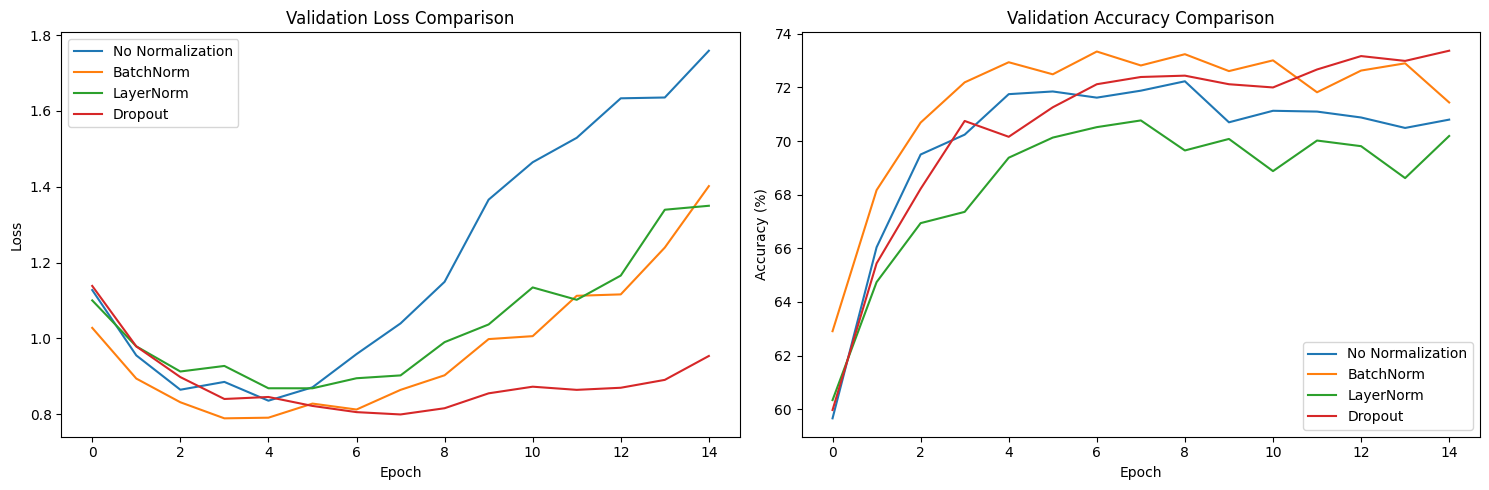

In [ ]:
plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]['val_loss'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]['val_acc'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
summary = []
for name in results:
    summary.append({
        'Model': name,
        'Train Accuracy (%)': results[name]['train_acc'][-1],
        'Val Accuracy (%)': results[name]['val_acc'][-1],
        'Test Accuracy (%)': results[name]['test_acc'],
        'Final Val Loss': results[name]['val_loss'][-1]
    })

df_results = pd.DataFrame(summary)
display(df_results)


,Model,Train Accuracy (%),Val Accuracy (%),Test Accuracy (%),Final Val Loss
0,No Normalization,98.1825,70.80,70.31,1.759010
1,BatchNorm,95.8750,71.44,70.80,1.401885
2,LayerNorm,93.6775,70.19,70.53,1.349991
3,Dropout,87.0300,73.37,73.21,0.953801


## Часть 2: Исследование различных архитектур нейронных сетей.
1.	Выбор архитектур:
*	Обучите три разные архитектуры сверточных сетей на одном и том же наборе данных (ResNet (Residual Networks), VGG (Very Deep Convolutional Networks) и MobileNet (для мобильных и маломощных устройств))
2.	Эксперименты:
*	Проведите обучение для 20 эпох, используя одинаковые гиперпараметры (learning rate, batch size).
*	Визуализируйте процесс обучения через TensorBoard или Matplotlib.
3.	Сравнительный анализ:
*	Сравните точность на тестовой выборке, количество параметров и время обучения каждой архитектуры.
*	Проанализируйте, какая архитектура лучше справляется с переобучением.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<ipython-input-16-8a7426e7a3a5>:61: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 101s 552ms/step - accuracy: 0.1167 - loss: 2.7214 - val_accuracy: 0.2110 - val_loss: 2.2223
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 524ms/step - accuracy: 0.1606 - loss: 2.2221 - val_accuracy: 0.1857 - val_loss: 2.1892
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 530ms/step - accuracy: 0.1808 - loss: 2.1804 - val_accuracy: 0.2365 - val_loss: 2.0959
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 505ms/step - accuracy: 0.1848 - loss: 2.1538 - val_accuracy: 0.2506 - val_loss: 2.0662
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 525ms/step - accuracy: 0.1877 - loss: 2.1324 - val_accuracy: 0.2622 - val_loss: 2.0609
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 518ms/step - accuracy: 0.1960 - loss: 2.1259 - val_accuracy: 0.2591 - val_loss: 2.0249
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 523ms/step - accuracy: 0.2016 - loss: 2.1071 - val_accuracy: 0.2659 - val_loss: 2.0154
Epoch 8/20
157/157 ━━━━━━━━━

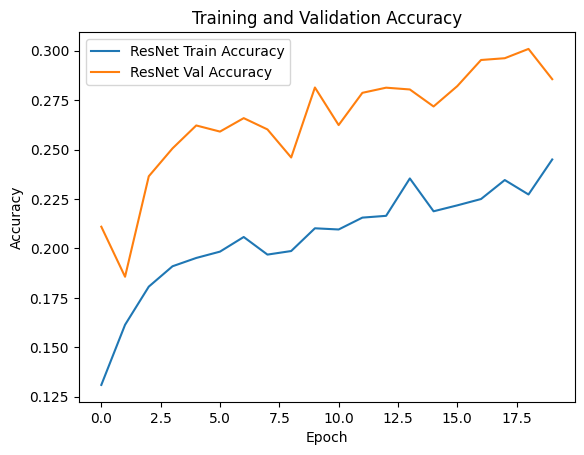

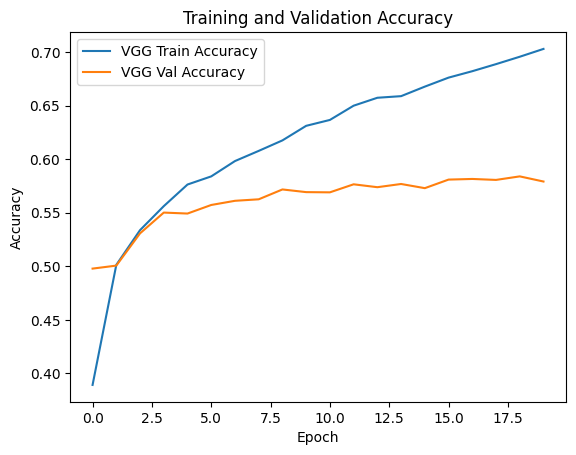

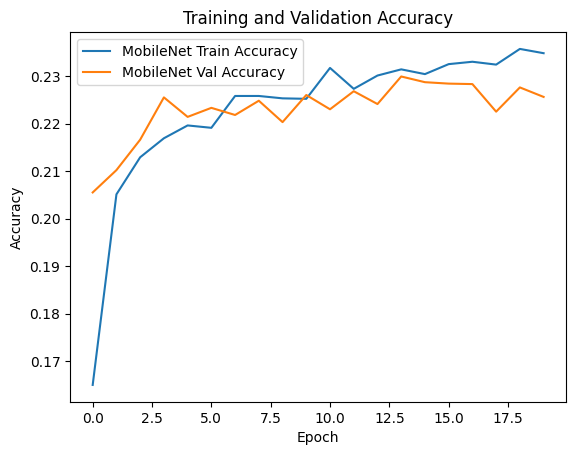

ResNet Results:
Test Accuracy: 0.2856000065803528
Training Time: 1828.5835819244385 seconds
Number of Parameters: 24641930
-----------------------------------
VGG Results:
Test Accuracy: 0.5791000127792358
Training Time: 4950.599949836731 seconds
Number of Parameters: 14982474
-----------------------------------
MobileNet Results:
Test Accuracy: 0.225600004196167
Training Time: 483.1481547355652 seconds
Number of Parameters: 3758794
-----------------------------------


In [ ]:
# Загрузка и подготовка данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

# Использование только части данных для обучения
subset_size = 10000  # Количество примеров для обучения
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Гиперпараметры
epochs = 20
batch_size = 64  # Увеличение размера батча
learning_rate = 0.001

# Функция для создания модели ResNet с fine-tuning
def create_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    base_model.trainable = False  # Замораживаем базовую модель
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для создания модели VGG с fine-tuning
def create_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    base_model.trainable = False  # Замораживаем базовую модель
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для создания модели MobileNet с fine-tuning
def create_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    base_model.trainable = False  # Замораживаем базовую модель
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для обучения модели
def train_model(model, name):
    tensorboard = TensorBoard(log_dir=f"logs/{name}")
    start_time = time.time()
    history = model.fit(x_train_subset, y_train_subset, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, y_test), callbacks=[tensorboard])
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time

# Обучение моделей
models = {
    "ResNet": create_resnet(),
    "VGG": create_vgg(),
    "MobileNet": create_mobilenet()
}

results = {}

for name, model in models.items():
    history, training_time = train_model(model, name)
    results[name] = {
        "history": history,
        "training_time": training_time,
        "test_accuracy": model.evaluate(x_test, y_test, verbose=0)[1]
    }

# Визуализация процесса обучения
for name, result in results.items():
    plt.plot(result["history"].history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(result["history"].history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Сравнительный анализ
for name, result in results.items():
    print(f"{name} Results:")
    print(f"Test Accuracy: {result['test_accuracy']}")
    print(f"Training Time: {result['training_time']} seconds")
    print(f"Number of Parameters: {models[name].count_params()}")
    print("-----------------------------------")
